In [6]:
from bs4 import BeautifulSoup
import requests as req
import pandas as pd
#resp = req.get('https://bilingualmanga.com/manga/yokohama-shopping-trip/chapter-4/1-8')
import urllib
#resp=req.get("https://bilingualmanga.com/manga/yokohama-shopping-trip/chapter-5/1-21")
#soup = BeautifulSoup(resp.text, 'lxml')
import os

In [36]:
def parse_color(key, string):
    assert key=="color"
    string=string.replace("rgb(","").replace(")","").split(", ")
    return string

def parse_number(key,string):
    size=string.split(", ")[0].replace("px","")
    return float(size)


def parseKnown(key,val):
    key_to_func={}
    key_to_func["left"]=parse_number
    key_to_func["top"]=parse_number
    key_to_func["width"]=parse_number
    key_to_func["font-size"]=parse_number
    key_to_func["color"]=parse_color

    if key in key_to_func:
        return key_to_func[key](key,val)
    else:
        return val


def extract_dictionary(element,additional_dict_values:dict={}):
    all_pairs=[]
    index=0
    for sub in element:
        style=sub.get_attribute_list("style")
        dictionary={}
        attribute_elements=style[0].split(";")
        for element in attribute_elements:
            pair= element.split(":")
            key=pair[0]
            val=pair[1]
            val=parseKnown(key,val)
            dictionary[key]=val
        dictionary["text"]=sub.getText().replace(",","")
        dictionary["box_id"]=index
        index+=1
        dictionary.update(additional_dict_values)
        all_pairs.append(dictionary)
    
    return all_pairs

def parse_soup_page(soup,link=""):
    
    link=""
    jp=soup.select("div.main.language")[0]
    eng=soup.select('div.language.sub')[0]
    eng_text=eng.findAll("div","div-text")
    jp_text=jp.findAll("div","div-text")
    
    
    sub=soup.findAll(False,{'class':['image-container']})[0]
    img_link=sub.find("img")
    jpg=img_link.attrs["src"]
    
    manga=soup.findAll(False,{'id':["manga-name"]})[0]
    manga=manga.text.replace(" ","_")
    print(manga)
    
    jp_dict={}
    eng_dict={}
    
    
    eng_dict=extract_dictionary(eng_text,{"language":"english","manga":manga})

  
    jp_dict=extract_dictionary(jp_text,{"language":"jp","manga":manga})
   
    

    translate=pd.DataFrame(jp_dict)
    translate=translate.append(eng_dict,True)
    translate["image"]=jpg
    translate["link"]=link
    
    next_page_href=""
    next_link=soup.select('div.btn-control-container')
    next_link=next_link[0].select('a')
    if len(next_link)>1:
        
        next_page_href=next_link[1]["href"]
    
    return translate


def save_file(dir_path,file_id,link):
    if os.path.isdir(dir_path)==False:
        os.mkdir(dir_path)
    
    path=os.path.join(dir_path,file_id)

    urllib.request.urlretrieve(link,path+".jpg")
    
def get_link(soup):
    
    next_page_href=""
    next_link=soup.select('div.btn-control-container')
    next_link=next_link[0].select('a')
    if len(next_link)>1:
        
        next_page_href=next_link[1]["href"]
    
    return next_page_href
    

In [59]:
#import argparse
#from selenium import webdriver
#import time

#from PIL import Image
#import os


def CreateWebDriver(path="chromedriver"):
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--headless')
    chrome_options.add_argument("--window-size=4000,3000")
    return webdriver.Chrome(
        path,
        options=chrome_options)


def SaveImage(driver, html_element, output):
    driver.save_screenshot(output)

    height = html_element.get_attribute("height")
    width = html_element.get_attribute("width")
    location = html_element.location
    size = html_element.size

    x = location['x']
    y = location['y']
    width = location['x'] + size['width']
    height = location['y'] + size['height']

    im = Image.open(output)
    im = im.crop((int(x), int(y), int(width), int(height)))
    im.save(output)


In [60]:
def save_eng_jp_pairs(driver,link,dir_path,file_id):
    if os.path.isdir(dir_path)==False:
        os.mkdir(dir_path)
    
    
    driver.get(link)
    time.sleep(1)
    path=os.path.join(dir_path,file_id)

    element=driver.find_element_by_class_name("image-container")
    
    SaveImage(driver,element,path+"_jp.png")
    driver.find_element_by_id("js-ripple-btn").click()
    time.sleep(.1)
    SaveImage(driver,element,path+"_en.png")

In [ ]:
link="https://bilingualmanga.com/manga/yokohama-shopping-trip/chapter-5/1-21"
resp=req.get("https://bilingualmanga.com/manga/yokohama-shopping-trip/chapter-1/1-2")

soup = BeautifulSoup(resp.text, 'lxml')
frame,next_link=parse_soup_page(soup,link)

In [4]:
def get_link(soup):
    
    next_page_href=""
    next_link=soup.select('div.btn-control-container')
    next_link=next_link[0].select('a')
    if len(next_link)>1:
        
        next_page_href=next_link[1]["href"]
    
    return next_page_href

In [56]:
def extract_manga(link,save_dir="/home/data/bilingual/"):

    all_frames=pd.DataFrame()
    for i in range(8):
        last_link=link
        resp=req.get(link)
        soup = BeautifulSoup(resp.text, 'lxml')

        link=get_link(soup) #link to next page
        
        frame=[]
        try:
            frame=parse_soup_page(soup,link)
            
        except:
            pass 

        link="https://bilingualmanga.com/"+link

        print(link)
        print(len(frame))
        if len(frame)!=0:
            frame["id"]=i
            frame["link"]=last_link
            all_frames=all_frames.append(frame)
     
            img_link=frame["image"].unique()[0]
            manga_name=frame["manga"].unique()[0]
            
            manga_dir=os.path.join(save_dir,manga_name)
            print(img_link)

            save_file(manga_dir,str(i),img_link)
    
    
    all_frames=all_frames.reset_index() 
    return all_frames

0     https://bilingualmanga.com/manga/my-son-is-pro...
1     https://bilingualmanga.com/manga/my-son-is-pro...
2     https://bilingualmanga.com/manga/my-son-is-pro...
3     https://bilingualmanga.com/manga/my-son-is-pro...
4     https://bilingualmanga.com/manga/my-son-is-pro...
                            ...                        
87    https://bilingualmanga.com//manga/my-son-is-pr...
88    https://bilingualmanga.com//manga/my-son-is-pr...
89    https://bilingualmanga.com//manga/my-son-is-pr...
90    https://bilingualmanga.com//manga/my-son-is-pr...
91    https://bilingualmanga.com//manga/my-son-is-pr...
Name: link, Length: 92, dtype: object

In [57]:
link="https://bilingualmanga.com/manga/my-son-is-probably-gay/chapter-1/1-4"
#link="https://bilingualmanga.com/"+link

b=extract_manga(link)

My_Son_Is_Probably_Gay
https://bilingualmanga.com//manga/my-son-is-probably-gay/chapter-2/1-1
26
https://3.bp.blogspot.com/-NWRAbkQkznc/XmHm_W-QQLI/AAAAAAAAE44/NjeA7sAy0TUQkS4hrSnyNpNRt2iIGMxiwCLcBGAsYHQ/s1600/4.jpg
My_Son_Is_Probably_Gay
https://bilingualmanga.com//manga/my-son-is-probably-gay/chapter-2/1-2
10
https://2.bp.blogspot.com/-JhmyRS-lruo/XqJ-J8UunxI/AAAAAAAAFN8/QRIyRKW_oF4iqz7msW1FYPUO-cgEdW6owCLcBGAsYHQ/s1600/1.png
My_Son_Is_Probably_Gay
https://bilingualmanga.com//manga/my-son-is-probably-gay/chapter-2/1-3
10
https://4.bp.blogspot.com/--Jy5X1U0lR8/XqJ-J-LxYlI/AAAAAAAAFOA/lpQ0IqVfrfImNhwzPP3iG8kMjlXCNFNwwCLcBGAsYHQ/s1600/2.png
My_Son_Is_Probably_Gay
https://bilingualmanga.com//manga/my-son-is-probably-gay/chapter-2/1-4
18
https://3.bp.blogspot.com/-kUuYWIF4imU/XqJ-KFezjcI/AAAAAAAAFOE/w-AHaYa25z4ibMEgxbFwq8Sg_oklhwIhACLcBGAsYHQ/s1600/3.png
My_Son_Is_Probably_Gay
https://bilingualmanga.com//manga/my-son-is-probably-gay/chapter-3/1-1
20
https://1.bp.blogspot.com/-dvuNoVf9Jxs/

In [53]:
b.link.values[0]

'https://bilingualmanga.com/manga/my-son-is-probably-gay/chapter-1/1-4'

In [25]:
all_frames.to_csv("temp.tsv",sep="\t",index=False)

In [28]:
pd.read_csv("temp.tsv",sep="\t")

,index,font-family,font-size,color,left,top,text-shadow,text,box_id,language,manga,-ms-transform,-webkit-transform,transform,width,image,link,id
0,0,"yasashisa-antique, sans-serif",26.0,"['0', '0', '0']",619.0,825.0,none,いいよ\n将来しょうらい食たべたく\nなったら,0,jp,My_Son_Is_Probably_Gay,NaN,NaN,NaN,NaN,https://4.bp.blogspot.com/-_-Q0q-WkEXE/XmHm-lu...,NaN,0
1,1,"yasashisa-antique, sans-serif",26.0,"['0', '0', '0']",120.0,851.0,none,料理りょうりが得とく意いな\n彼かれ氏しに作つくって\nもらうからー,1,jp,My_Son_Is_Probably_Gay,NaN,NaN,NaN,NaN,https://4.bp.blogspot.com/-_-Q0q-WkEXE/XmHm-lu...,NaN,0
2,2,"yasashisa-antique, sans-serif",18.0,"['0', '0', '0']",564.0,562.0,none,将来しょうらいあんたは\nこのカレーが\n無性むしょうに食たべたく\nなるのよ,2,jp,My_Son_Is_Probably_Gay,NaN,NaN,NaN,NaN,https://4.bp.blogspot.com/-_-Q0q-WkEXE/XmHm-lu...,NaN,0
3,3,"yasashisa-antique, sans-serif",18.0,"['0', '0', '0']",681.0,484.0,none,いわゆる\nおふくろの味あじって\nやつだねー,3,jp,My_Son_Is_Probably_Gay,NaN,NaN,NaN,NaN,https://4.bp.blogspot.com/-_-Q0q-WkEXE/XmHm-lu...,NaN,0
4,4,"yasashisa-antique, sans-serif",19.0,"['0', '0', '0']",80.0,538.0,none,えー？ だって\nコーン入いれるだけ\nでしょ？,4,jp,My_Son_Is_Probably_Gay,NaN,NaN,NaN,NaN,https://4.bp.blogspot.com/-_-Q0q-WkEXE/XmHm-lu...,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,15,"anime-ace, sans-serif",16.0,"['0', '0', '0']",378.0,752.0,none,has something changed about the recipe!?,5,english,My_Son_Is_Probably_Gay,NaN,NaN,NaN,132.0,https://1.bp.blogspot.com/-dvuNoVf9Jxs/XqJ-Klr...,NaN,7
134,16,"anime-ace, sans-serif",12.0,"['0', '0', '0']",233.0,443.0,none,my son is probably gay,6,english,My_Son_Is_Probably_Gay,NaN,NaN,NaN,91.0,https://1.bp.blogspot.com/-dvuNoVf9Jxs/XqJ-Klr...,NaN,7
135,17,"anime-ace, sans-serif",15.0,"['0', '0', '0']",106.0,427.0,none,he's a little obvious but his heart is in the ...,7,english,My_Son_Is_Probably_Gay,NaN,NaN,NaN,107.0,https://1.bp.blogspot.com/-dvuNoVf9Jxs/XqJ-Klr...,NaN,7
136,18,"anime-ace, sans-serif",14.0,"['0', '0', '0']",216.0,933.0,none,i didn't change anything,8,english,My_Son_Is_Probably_Gay,NaN,NaN,NaN,111.0,https://1.bp.blogspot.com/-dvuNoVf9Jxs/XqJ-Klr...,NaN,7


In [162]:
subset=all_frames[all_frames["manga"]=="Yokohama_Shopping_Trip"]

In [179]:
subset[(subset.id==5)&(subset.box_id==3)]["text"]

31                            いいよ\n今日きょうは\nサービスだ！
41    take care now. the roads aren't too good...
Name: text, dtype: object

In [158]:
%%time
subset[subset.index.unique()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 265 µs


Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73],
           dtype='int64')

In [49]:
frame["manga"].unique()[0]

'Yokohama_Shopping_Trip'

In [19]:
import urllib.request
def save_img_soupy(directory,manga_name,link):
   

In [24]:
!ls /home/data

Manga109s  manga109s.zip


In [26]:
#os.mkdir( path, 0755 )
import os

In [32]:
#os.system("sudo mkdir {}".format("/home/data/bilingual/temp"))
#os.mkdir("/home/data/bilingual/temp")

0

In [37]:
os.mkdir("/home/data/bilingual/temp")
os.path.isdir("/home/data/bilingual/temp")

True

In [66]:
img_link=frame["image"].unique()[0]
manga_name=frame["manga"].unique()[0]

In [67]:
manga_dir=os.path.join("/home/data/bilingual",manga_name)
file_path=os.path.join(manga_dir,str(1))

In [68]:
save_file(manga_dir,"1",img_link)

In [69]:
!cp "/home/data/bilingual/Yokohama_Shopping_Trip/1.jpg" "1.jpg"
#save_file( os.path.join("/home/data/bilingual",manga_name), frame["image"].unique()[0]

In [54]:
style=sub.get_attribute_list("style")

attribute_elements=style[0].split(";")

In [55]:
font_family=attribute_elements[0]
key=font_family.split(":")[0]
fonts=font_family.split(":")[1].split(", ")

In [85]:
font_size=attribute_elements[1]
key=font_size.split(":")[0]
size=font_size.split(":")[1]   #.split(", ")

In [86]:
key

'font-size'

In [79]:
color=attribute_elements[2]
key=color.split(":")[0]
vals=color.split(":")[1]

In [82]:
parse_color(key,vals)

['0', '0', '0']

In [22]:
import json 
json.loads(str(soup))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [28]:
import os
import sys
import numpy as np

import cv2
from matplotlib.pyplot import imshow

In [29]:
image=cv2.imread("8.jpg",cv2.IMREAD_COLOR)

In [30]:
image.shape

(1100, 730, 3)

In [32]:
image2=cv2.imread("temp.png",cv2.IMREAD_COLOR)

In [37]:
image2=image2[:1100,:,:]

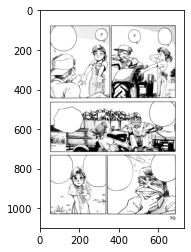

In [34]:
imshow(image)

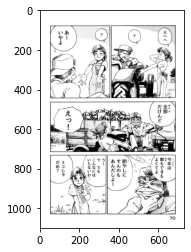

In [38]:
imshow(image2)

In [43]:
image2.T[0][0:100]

array([[ 73, 130, 215, ..., 215, 130,  73],
       [127, 255, 255, ..., 255, 255, 127],
       [213, 255, 255, ..., 255, 255, 213],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
imshow(image.T[0][0:100,:])

In [ ]:
imshow(image2.T[0][0:100,:])

In [ ]:
imshow(image2.T[0][0:100,:]+(image.T[0][0:100,:]))

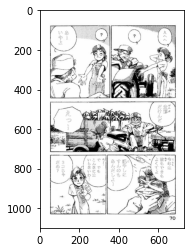

In [53]:
imshow((image2+image))